# Credit Risk Prediction with Machine Learning


The dataset can be downloaded from Kaggle on [this](https://www.kaggle.com/btolar1/weka-german-credit) link.

The dataset contains 1000 entries with 20 categorial/symbolic attributes. In this dataset,
each entry represents a person who takes a credit by a bank. Each person is classified as
good or bad (`class`) credit risk according to a set of attributes. This will be our target variable. 


In [116]:
import pandas as pd
import numpy as np
import joblib
import time
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import seaborn as sns; sns.set()

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.metrics import make_scorer, RocCurveDisplay

from imblearn.metrics import specificity_score

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# Make sure that we can see all columns in the ouputs
pd.set_option('display.max_columns', 25)

Assuming the dataset is downloaded and stored in the `datasets` folder, we can load the data into Pandas as follows.

## Data Preparation and Data Exploration

In [2]:
# Start by loading the data and displaying the top 5 rows
credit = pd.read_csv("../datasets/credit-g.csv")
credit.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,none,4,real estate,67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,none,2,real estate,22,none,own,1,skilled,1,none,yes,bad
2,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,none,3,real estate,49,none,own,1,unskilled resident,2,none,yes,good
3,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,guarantor,4,life insurance,45,none,for free,1,skilled,2,none,yes,good
4,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,none,4,no known property,53,none,for free,2,skilled,2,none,yes,bad


Display some extra information and descriptive statistics

In [3]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   checking_status         1000 non-null   object
 1   duration                1000 non-null   int64 
 2   credit_history          1000 non-null   object
 3   purpose                 1000 non-null   object
 4   credit_amount           1000 non-null   int64 
 5   savings_status          1000 non-null   object
 6   employment              1000 non-null   object
 7   installment_commitment  1000 non-null   int64 
 8   personal_status         1000 non-null   object
 9   other_parties           1000 non-null   object
 10  residence_since         1000 non-null   int64 
 11  property_magnitude      1000 non-null   object
 12  age                     1000 non-null   int64 
 13   other_payment_plans    1000 non-null   object
 14  housing                 1000 non-null   object
 15  exist

In [4]:
credit.describe()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


In [5]:
# Calculate the number of unique values in each column
credit.nunique()

checking_status             4
duration                   33
credit_history              5
purpose                    10
credit_amount             921
savings_status              5
employment                  5
installment_commitment      4
personal_status             4
other_parties               3
residence_since             4
property_magnitude          4
age                        53
 other_payment_plans        3
housing                     3
existing_credits            4
job                         4
num_dependents              2
own_telephone               2
 foreign_worker             2
class                       2
dtype: int64

From above outputs we learn, among other things:

- There are as little as 1,000 rows and 21 columns in the dataset (including the target variable). Seemingly no missing values. 
- Some column names contain empty strings which can be removed to make our work easier.
- Half of the loans should be paid back within 18 months.
- 75% of the credit amounts are below 4,000, while the average is around 3,300. Highest is 18k. Relatively low. Seems like these can be fast loans, a.k.a SMS loans or similar. 
- The average age is around 36 years.
- Most of the variables have few unique values. Only `duration`, `credit_amount` and `age` have more than 10 unique values. 

We can additionally plot categorical and numerical variables to get a better understanding of their distribution. 

Start by cleaning up the column names though.

In [6]:
# Clean up column names
credit.columns = credit.columns.str.strip()

### Numerical Variables

Let's plot the distribution of the numerical variables; `duration`, `credit_amount` and `age`. We can argue whether `duration` and `age` are discrete or continuous, but for the purpose of plotting, we can use the same approach. Split by `class` to get an understanding of the difference in distribution.

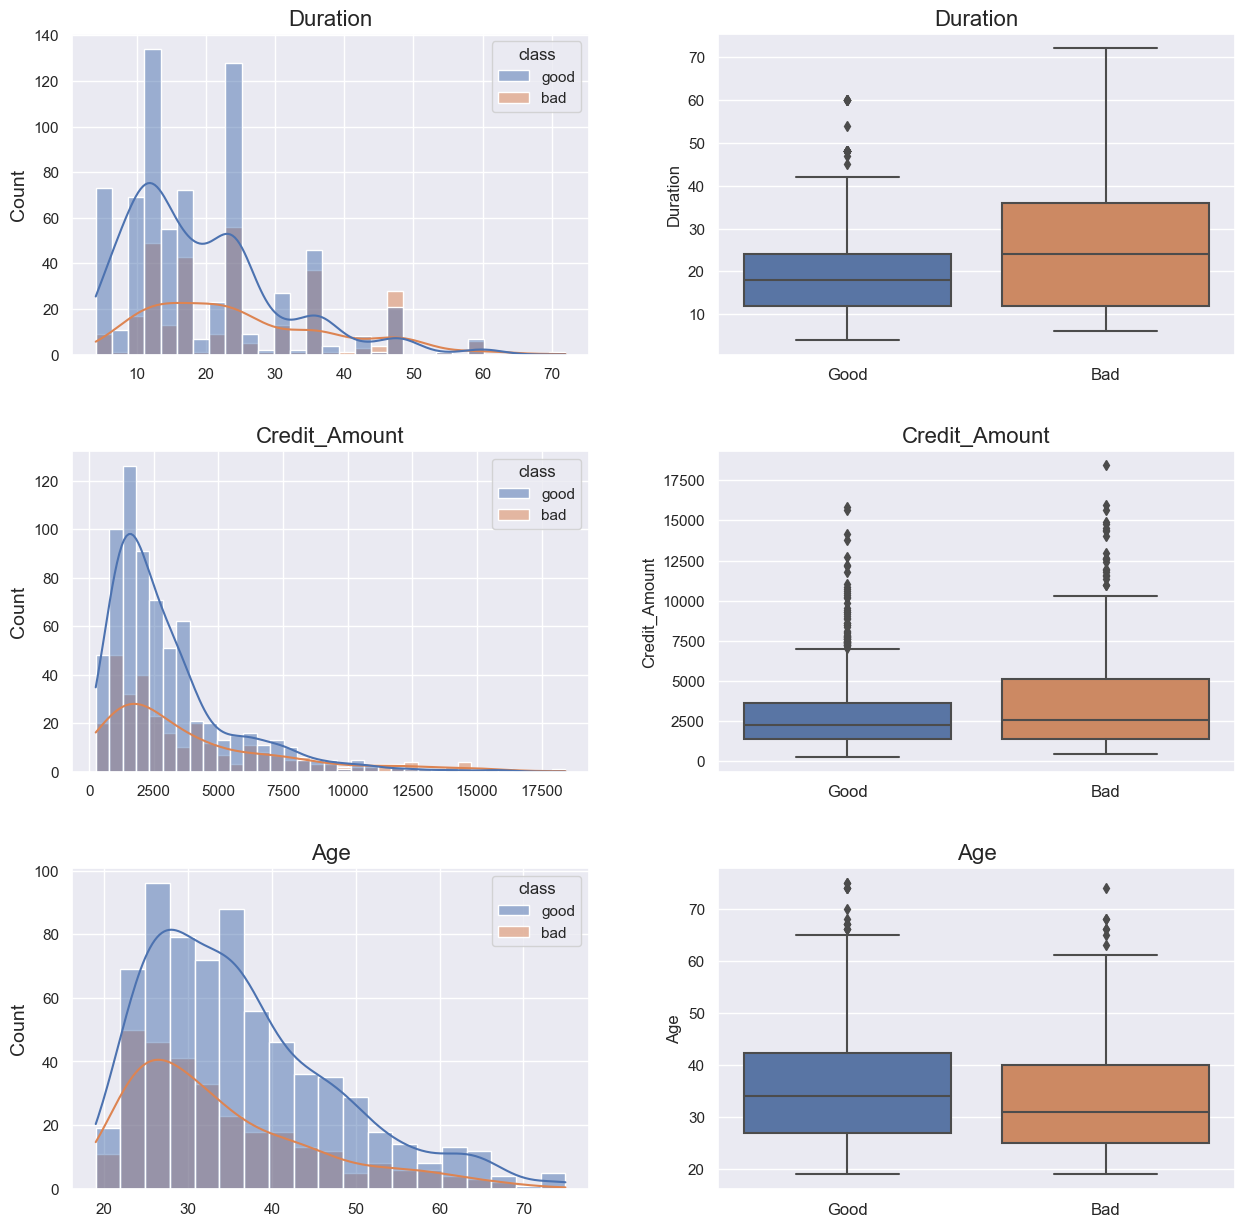

In [7]:
# Select numerical variables
numerical = ['duration', 'credit_amount', 'age']

# Specify plot size and loop over each variable
plt.figure(figsize=(15, 15))
i = 1
for col in numerical:   
    # Plot the data using histograms, split by class
    plt.subplot(3, 2, i)
    sns.histplot(x=col, data=credit, hue='class', kde=True)
    plt.title(col.title(), size=16)
    plt.xlabel("")
    plt.ylabel("Count", size=14)
    
    # Plot the data using Boxplots
    plt.subplot(3, 2, i+1)
    ax = sns.boxplot(x='class', y=col, data=credit)
    ax.set_xticklabels(["Good", "Bad"], size=12)
    plt.title(col.title(), size=16)
    plt.ylabel(col.title(), size=12)
    plt.xlabel("")
    
    i += 2
    
plt.subplots_adjust(hspace=0.3, wspace=0.25)

- The median duration for bad credit risk is slightly higher than for good credit risk. 
- Most credits are lower than 5,000. 75% are lower than 4,000 as we saw earlier. 
- Most credits are taken by relatively young people - 40 or younger. Those with bad credit risk are in general slightly younger. 
- Although none are extreme, there are some outliers. This can and should be confirmed with a statistical method such as the *z-score* or *Tukey's method*. The boxplots above are based on the same interquartile range (IQR) method as Tukey's method. Using the standard threshold of 1.5 * IQR we see that there are quite a lot of outliers in the `credit_amount` column. However, all in all, most values seem reasonable and we can leave them as they are for now. 


By a visual inspection, none of the distributions seem normal. We should test for normality with a test such as Shapiro-Wilk though. For samples sizes > 5,000 the test statistic is accurate but the p-value might not be. Since our sample size is 1,000, both should be accurate.

In [8]:
print("Duration:")
print(stats.describe(credit["duration"]))
print(stats.shapiro(credit["duration"]))

print("\nCredit Amount:")
print(stats.describe(credit["credit_amount"]))
print(stats.shapiro(credit["credit_amount"]))

print("\nAge:")
print(stats.describe(credit["age"]))
print(stats.shapiro(credit["age"]))

Duration:
DescribeResult(nobs=1000, minmax=(4, 72), mean=20.903, variance=145.41500600600605, skewness=1.0925422109540106, kurtosis=0.9091948811374047)
ShapiroResult(statistic=0.8997893929481506, pvalue=4.908334953558791e-25)

Credit Amount:
DescribeResult(nobs=1000, minmax=(250, 18424), mean=3271.258, variance=7967843.470906908, skewness=1.946702018941924, kurtosis=4.265163377213492)
ShapiroResult(statistic=0.7933971881866455, pvalue=8.609912964372653e-34)

Age:
DescribeResult(nobs=1000, minmax=(19, 75), mean=35.546, variance=129.4012852852853, skewness=1.019207521364841, kurtosis=0.5868108307295379)
ShapiroResult(statistic=0.9174712896347046, pvalue=6.382233715302455e-23)


Although both skweness and kurtosis fall within the threshold of normality (roughly ±3) for all three variables (except perhaps kurtosis for `credit_amount`), based on the visualisations and the Shapiro-Wilk test, we can reject that the distributions are normal. 

We can additionally plot the numerical variables against each other using a combination of scatter and kde plots. This allows us to better see how the variables are affected by each other. By also fitting regression lines, it becomes slightly easier to interpret. 

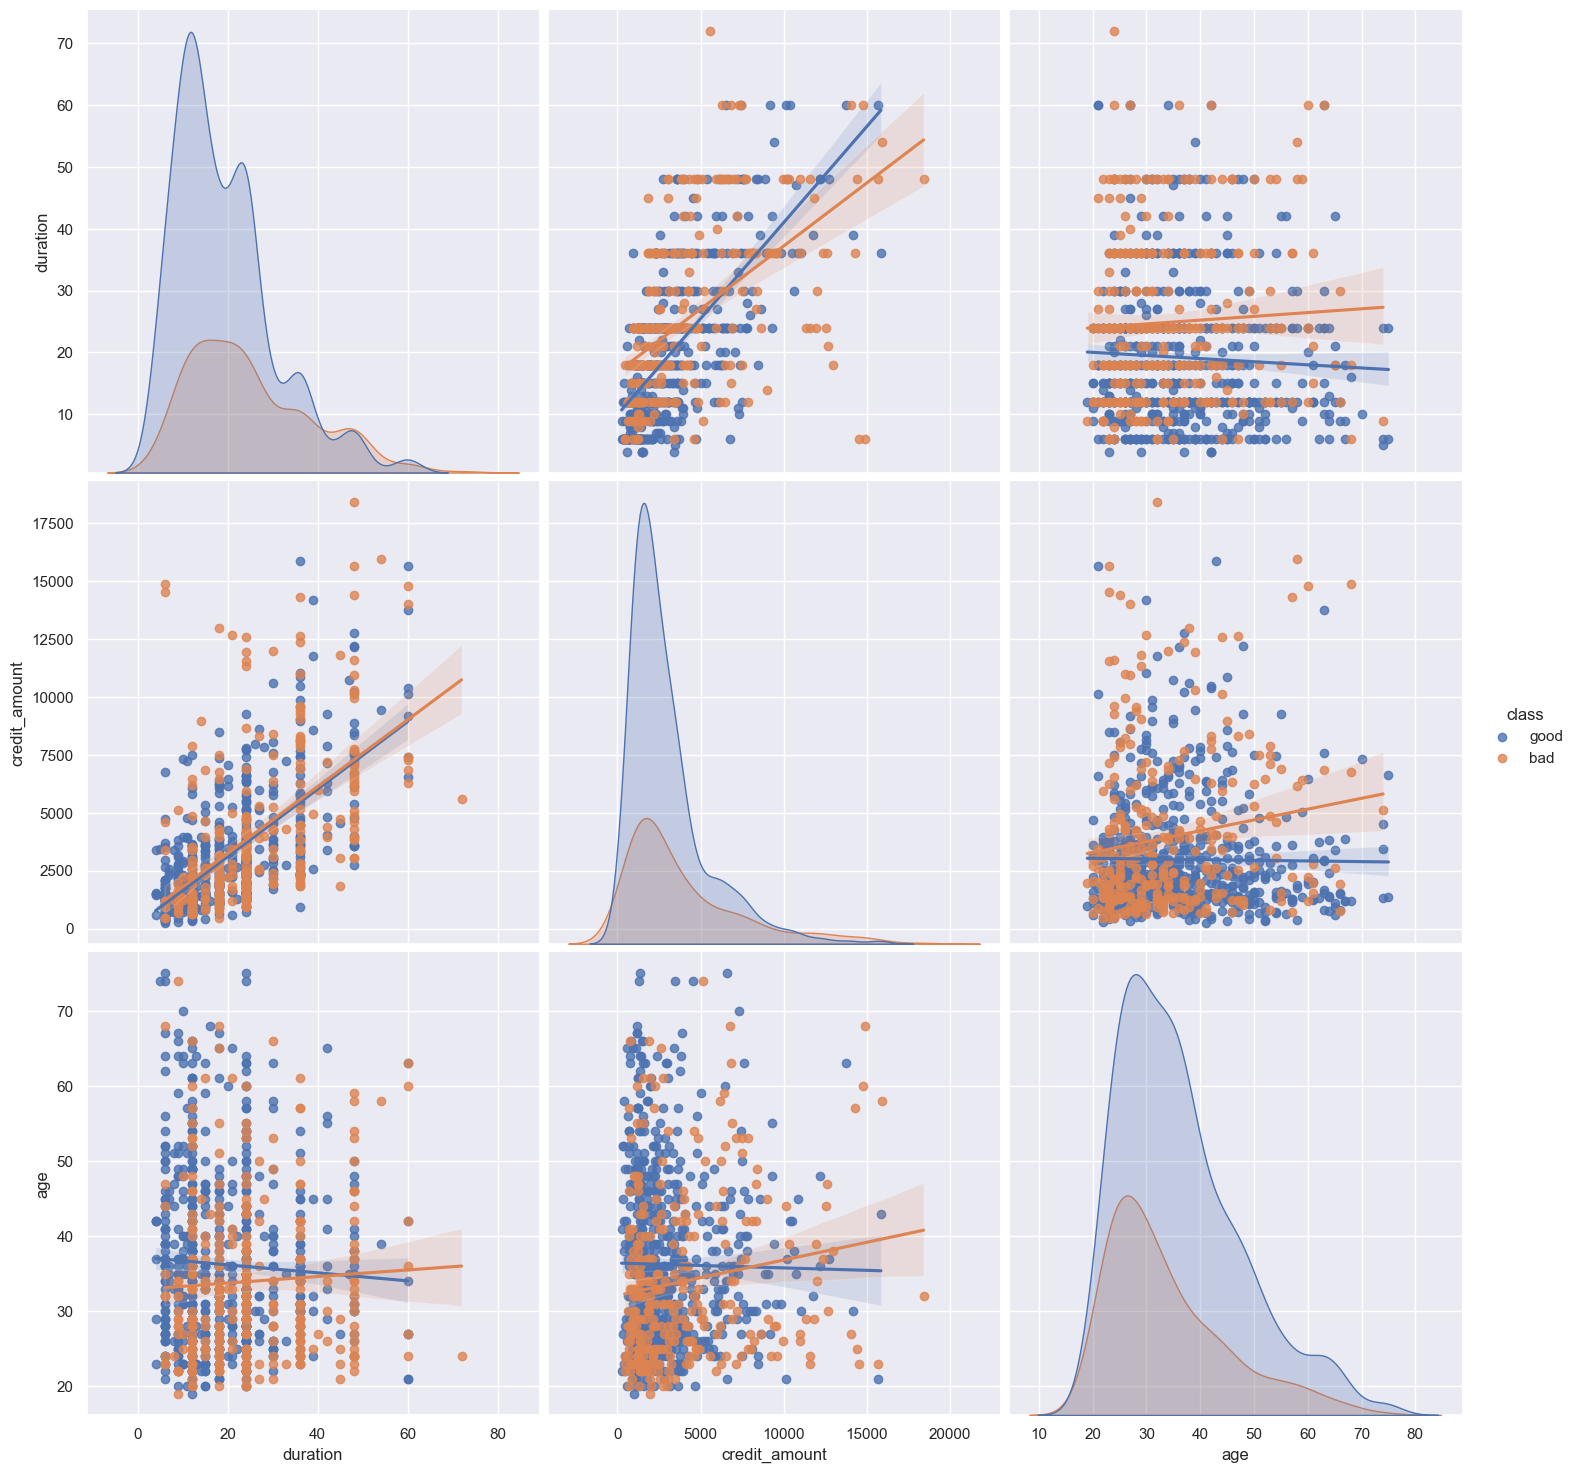

In [9]:
# Plot numerical variables against each other
sns.pairplot(credit[numerical+["class"]], hue="class", 
             kind='reg', height=5);

We note that there seem to be a strong correlation between `duration` and `credit_amount`, while it's significantly weaker between `duration` and `age` and between `credit_amount` and `age`. 

It's reasonable that with larger `credit_amount`s, it also takes more time to pay it back. 

Apparently, neither `duration` nor `credit_amount` are much affected by the age of the person taking the credit. This is somehow reasonable as there can be other factors that play bigger roles, such as the person's economical situation at the time, number of dependents (kids), employment etc., etc. 

### Categorical Variables

Plot the categorical variables to display their respective class counts.

The columns `installment_commitment`, `residence_since`, `existing_credits` and `num_dependents` are all discrete ordinal variables, meaning that there is a natural ordering of the values. As for the purpose of visualisation, we can plot them using the same approach as the categorical variables. 

Other columns, such as `checking_status` and `employment` probably possess similar characteristics, but they already count as categorical.

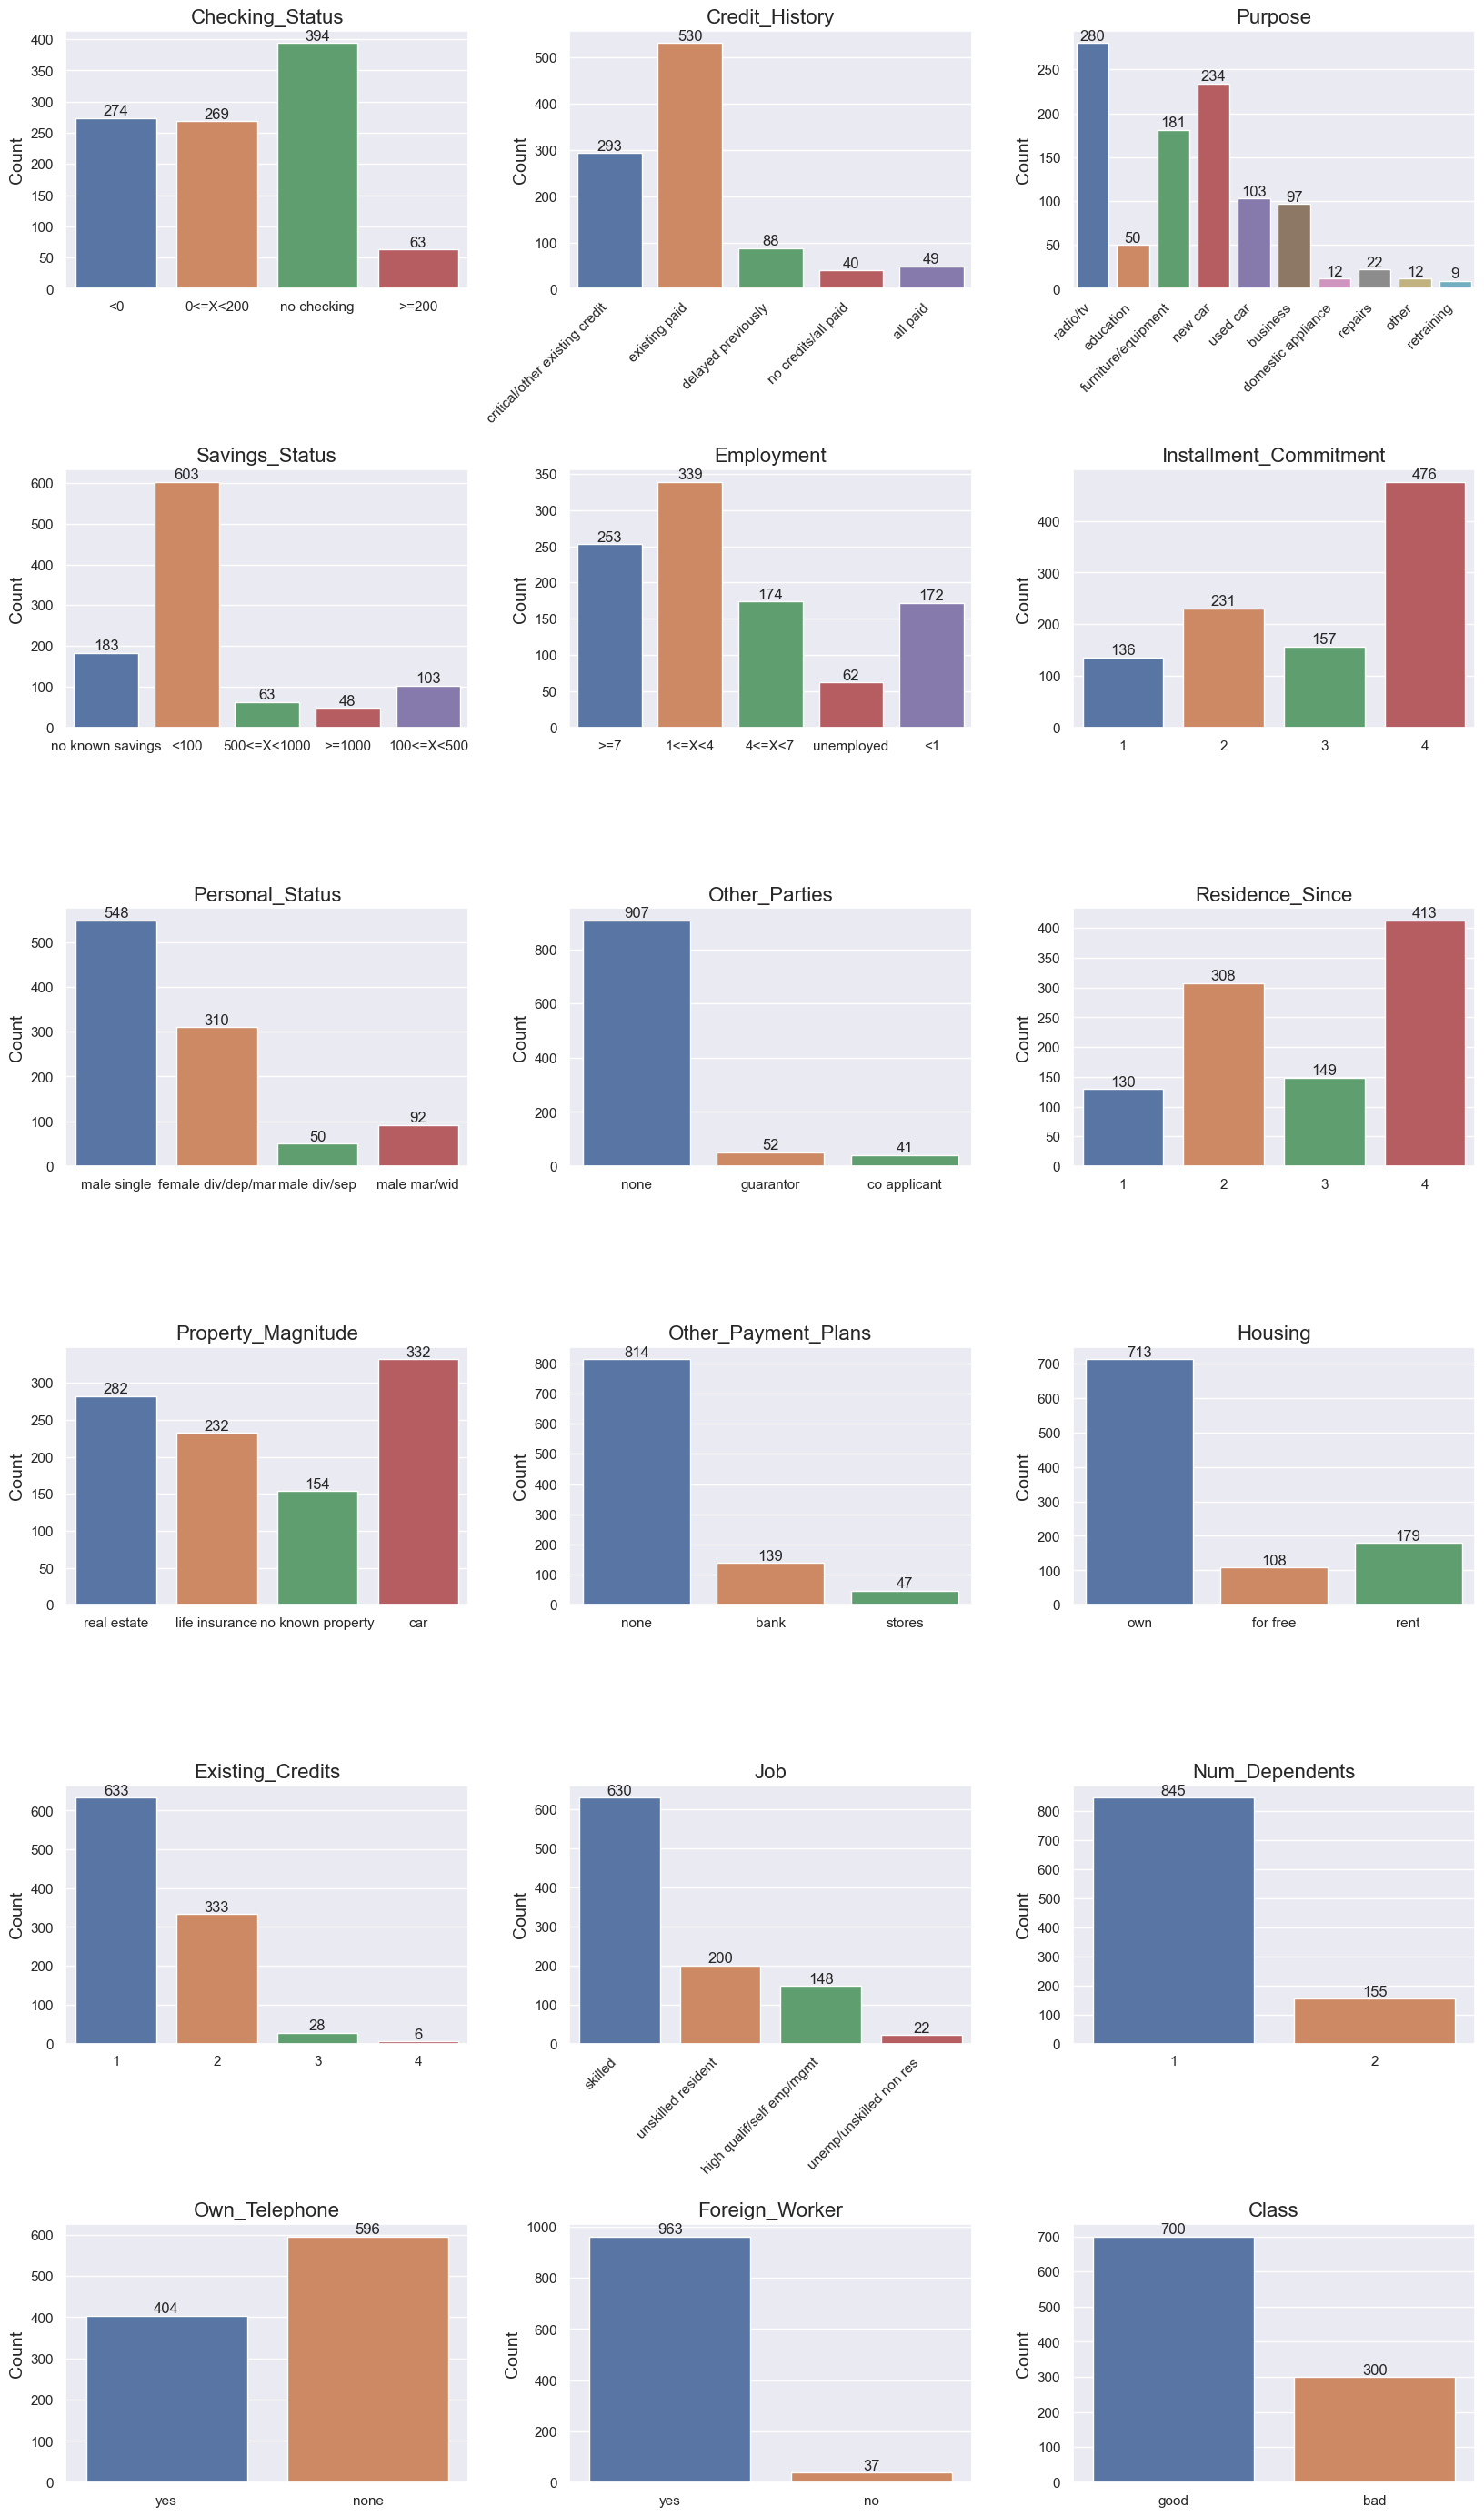

In [10]:
# Select categorical variables
categorical = [col for col in credit.columns if col not in numerical]

plt.figure(figsize=(20, 35))
for i, col in enumerate(credit[categorical], 1):
    
    # Plot corresponding variable
    plt.subplot(6, 3, i)
    ax = sns.countplot(x=col, data=credit)
    
    # Adjust labels and title. Display each class count
    plt.xlabel("")
    plt.ylabel("Count", size=14)
    plt.title(col.title(), size=16)
    ax.bar_label(ax.containers[0])
    
    # Rotate long class names in some columns to make them easier to read
    if col in ['credit_history', 'purpose', 'job']:
        plt.xticks(rotation=45, horizontalalignment='right')
        
plt.subplots_adjust(hspace=0.7, wspace=0.25)

Among other things, we learn the following by studying above plot. I've added some additional comments and thoughts as well.

- There are five or fewer classes in each categorical column. Only `purpose` has more with 10.
- Most seem to take credit to buy a radio/tv, a new car or furniture. Hardly solid investments I'd say.
- 60% have few savings (`savings_status` = `<100`).
- Relatively few are unemployed (6.2%). 
- 55% are single males. Why do males make up three classes while females only one?
- 91% take the credit on their own. 
- 71% own their apartment/house. This is great!
- 63% have one existing credit. 
- 63% have skilled job types while additionally 15% have highly skilled job types. 
- 85% of credit takers have one dependent they need to provide for. 
- Only 40% own a telephone. The data is probably not from this nor the previous decade (or perhaps, they refer to cell phones rather than the old school phones?).  
- 96% are foreign workers. Is this really representative of the population or are we looking at a very biased sample?
- We have a slightly unbalanced dataset. 70% have good credit rating (`class = good`), while 30% have bad. (**This is the target variable**.)


Since the largest class make up 70% of the data, a perfectly naive model that always predicts this class would achieve 70% accuracy. This would obvisouly not be helpful, and our models should thus at least have an accuracy of 70% to be useful. **Baseline model accuracy is therefore: 70%.**


Note that the differences in counts in each variable should be checked using more formal statistical tests. The *chi-square test* is a common option - it can check all categorical columns at once.

<br>

## Identify Features with the strongest Correlation to Credit Risk

There are many approaches we can take here. One way is to train a model and calculate the importance each feature has for predicting the target variable. Depending on the choice of algorithm, the importance is normally referred to as *feature importance* or *model coefficients*. 

We can also train many models, starting out with the entire feature set, and remove one-by-one the feature that contributes the least until we end up with the top three. With this approach you are most likely to find the "best" feature set. However, this takes comparably a lot of time and we won't do that here. 

Instead, we will calculate Pearson correlation coefficent for all features relative the target variable and display the results in a correlation matrix. It's a very fast approach while also providing us with a nice overview of each feature's contribution and their inter-correlations. The disadvantage is that features are only selected based on their *individual* contribution rather than *combined* contribution with other features. 

We will start by reordering the columns so the target variable is the first column. This will make it easier to interpret the correlation matrix.

In [11]:
# Reorder columns so the target variable is at the first position
cols = list(credit.columns)
cols.remove('class')
cols.insert(0, 'class')
credit = credit[cols]

# Randomly shuffle the data to minimise the effect of randomness on our results
credit_enc = credit.sample(frac=1.0, random_state=55)

Next, we have to convert all columns into numerical to be able to calculate correlations. To facilitate, we convert the target variable in the same way by using the `OrdinalEncoder`.

In [12]:
# Select all categorical columns
categorical = credit_enc.select_dtypes(include=['object']).columns

# Define encoder. As we are dealing with categorical variables, make sure that the output are integers
oe = OrdinalEncoder(dtype=np.int64)

# Transform the categorical columns
credit_enc[categorical] = oe.fit_transform(credit_enc[categorical])

# Verify that it looks as expected
credit_enc.head()

,class,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
458,1,1,6,3,1,343,2,2,4,0,2,1,3,27,1,1,1,1,1,0,1
387,1,0,18,1,3,7374,2,4,4,3,2,4,1,40,2,1,2,0,1,1,1
532,1,3,12,2,9,1503,2,0,4,2,2,4,3,41,1,2,1,1,1,0,1
895,1,3,36,2,9,8947,4,1,3,3,2,2,0,31,2,1,1,0,2,1,1
239,1,1,30,3,6,2522,2,3,1,3,1,3,1,39,1,1,1,1,2,0,1


Calculate and display Pearson correlation matrix.

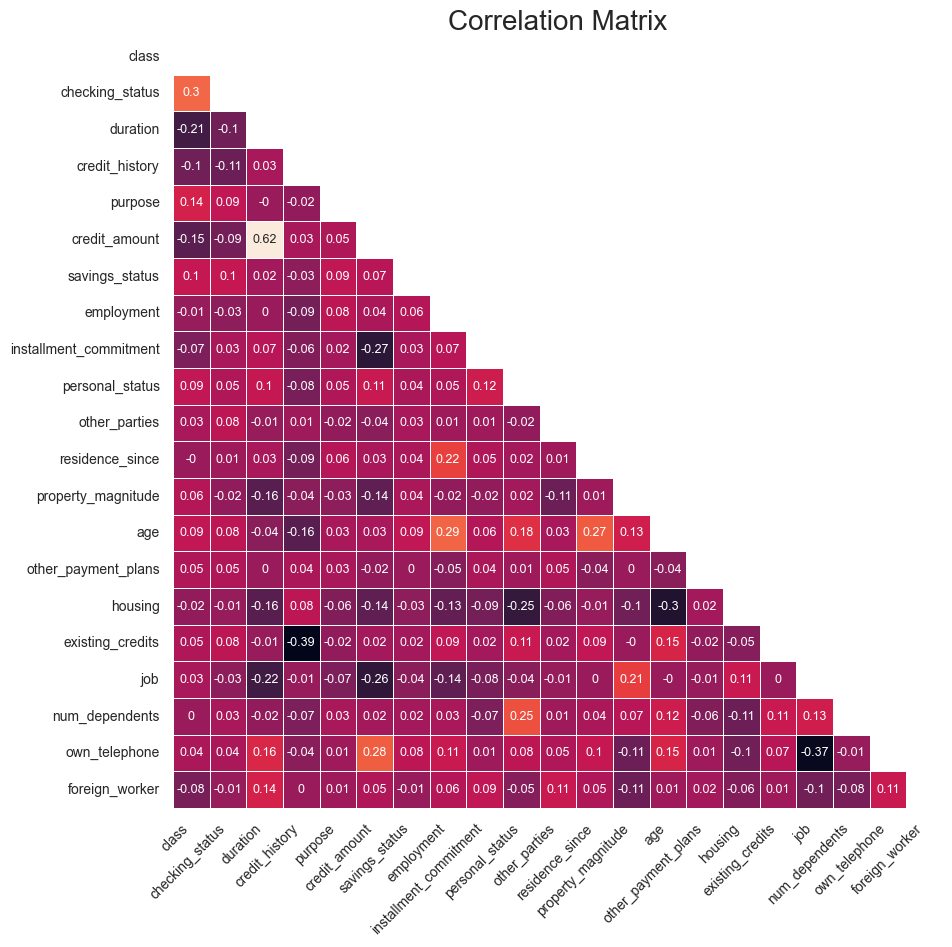

In [13]:
# Calculate correlation matrix
corr = credit_enc.corr()

# Create mask to remove the mirrored diagonal of the matrix
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Plot correlation matrix
plt.figure(figsize=(10, 10))
with sns.axes_style("white"):
    sns.heatmap(np.round(corr, 2), square=True,  annot=True,  
                cbar=False,  linewidth=.5, mask=mask, annot_kws={"size": 9})
    
plt.title("Correlation Matrix", size=20)
plt.xticks(size=10, rotation=45, horizontalalignment='right')
plt.yticks(size=10);

We find that `checking_status`, `duration` and `credit_amount` are highest correlated with the target variable. Note that we consider the absolute value since we don't really care wheather the target variable is positively or negatively affected by a particular feature.

Additionally, we observe that there is little collinearity and that there are many variables that barely have any correlation with the target variable (e.g. `num_dependents`, `residence_since` and `employment`). The previously identified strong correlation between `credit_amount` and `duration` is confirmed. 

Now when we have a slightly better general understanding, we can automate the selection of the top features using Scikit-learn's `SelectKBest` and the chi-squared stats `chi2` methods. There's a lot of experimentation we can do to find the optimal set of features, but to keep it simple, I will quite arbitrarly select the top 10. Note that we're also not considering any feature engineering. 

Before that, we split the data into feature set (`X`) and target (`Y`).

In [155]:
# Select features and target variable
X = credit_enc[credit_enc.columns.difference(['class'])]
Y = credit_enc['class']

In [156]:
# Select the top 10 most important features using chi-squared
selector = SelectKBest(chi2, k=10).fit(X, Y)
X = pd.DataFrame(selector.transform(X), 
                 columns=selector.get_feature_names_out()) 

# Display the resulting feature set
X.head()

,age,checking_status,credit_amount,credit_history,duration,installment_commitment,personal_status,property_magnitude,purpose,savings_status
0,27,1,343,3,6,4,0,3,1,2
1,40,0,7374,1,18,4,3,1,3,2
2,41,3,1503,2,12,4,2,3,9,2
3,31,3,8947,2,36,3,3,0,9,4
4,39,1,2522,3,30,1,3,1,6,2


Next, we'll split into train and test sets, keeping 80% for training and 20% for testing.

In [157]:
# Split into train and test sets. 
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=89)
trainX.head()

,age,checking_status,credit_amount,credit_history,duration,installment_commitment,personal_status,property_magnitude,purpose,savings_status
530,52,3,936,1,9,4,3,0,2,1
586,40,1,3939,1,11,1,3,3,4,2
601,32,3,2697,3,9,1,3,3,6,2
993,37,0,1154,1,9,2,3,3,6,2
848,25,0,1295,3,12,3,0,0,4,2


## Model the Credit Risk & Evaluate model performance

We are working with a fairly small dataset at 1,000 rows. This means that there is a significant risk that when we split it into train and test sets *only once*, we might be "lucky" and end up with all the "easy" samples in the test set by pure chance. This would lead to better than expected results on the test set and a seemingly better model than we think we have. Conversely, the opposite can happen as well.

A safer approach is to split the data many times in different ways and average the results. This way we are less likely to over-estimate the model performance by pure chance. This is referred to as cross-validation. We will use 10-fold cross-validation as it is frequently used and normally works well. Since the dataset is small, it shouldn't take too long to run either. 

It's common to experiment a lot during model development. But in order to speed things up, we will do a light version of it. Thus, we will evaluate three different models; Logistic Regression, Random Forest and LightGBM. Additionally, we will also do basic parameter tuning to optimize the models, while making sure to use nested cross-validation to not bias the results. 

For Logistic Regression, we need to scale the data for the model to properly learn. If a feature is significantly larger than the others (such as `credit_amount` vs `checking_status`), the model might over-estimate the importance of that feature, often leading to worse results. We can use `StandardScaler` to center the data round 0. Tree-based models such as Random Forest and LightGBM don't need this. 

A `Pipeline` will make sure that these steps are conducted properly by preventing data leakage.

We will use `AUC` as the main evaluation metric to tune and compare the trained models. It's a comparably complete metric that takes into account both True Positive and False Positive rates. Additionally, we will measure specificity, recall and accuracy to get a more holistic picture of the model performance. 



### Logistic Regression

Start by training and evaluating a Logistic regression model. We will tune the regularisation strength `C`. *Lower* values mean *more* regularization, which normally helps the model to better generalise to unseen data. We can use Scikit-Optimize's `BayesSearchCV` for this, which smoothly integrates with scikit-learn models. 

In [98]:
%%time

# Specify model and subsequent hyperparameters to tune
lr = LogisticRegression(max_iter=1000)
parameters = {
        'clf__C': Real(1e-3, 1e+2, prior='log-uniform'),
}

# Create final pipeline
pipeline = Pipeline(steps=([('scaler', StandardScaler()),
                            ('clf', lr)]))

# Specify scoring metrics
scoring = {
        "auc"        : "roc_auc",
        "specificity": make_scorer(specificity_score, average="weighted"),
        "recall"     : "recall",
        "accuracy"   : "accuracy",
}

# Perform hyperparameter tuning with BayesSearchCV over 10 folds with AUC as refit metric.
gs_lr = BayesSearchCV(pipeline, parameters, cv=10, scoring=scoring, 
                      refit="auc", random_state=500, n_iter=10)

# We need to fit the BayesSearchCV object to the train data in order to make predictions with the best model later
gs_lr.fit(trainX, trainY)

# Run nested cross-validation over 10 folds
lr_scores = cross_validate(gs_lr, X, Y, cv=10, n_jobs=-1, verbose=1,
                        return_train_score=True, scoring=scoring)

# Make cross-validated predictions 
lr_preds = cross_val_predict(pipeline, X, Y, cv=10, n_jobs=-1)

time.sleep(1)
for score in lr_scores:
        print(f"{score:<17}: {np.mean(lr_scores[score]):.2f}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    1.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.6s finished


fit_time         : 0.94
score_time       : 0.00
test_auc         : 0.74
train_auc        : 0.76
test_specificity : 0.41
train_specificity: 0.42
test_recall      : 0.95
train_recall     : 0.96
test_accuracy    : 0.72
train_accuracy   : 0.73
CPU times: user 2.71 s, sys: 1.65 s, total: 4.35 s
Wall time: 3.48 s


In [151]:
# Save best LR model pipeline
best_lr_model = gs_lr.best_estimator_
print(f"Best model:\n{gs_lr.best_estimator_}")
joblib.dump(best_lr_model, 'models/lr_model_pipeline.pkl')

Best model:
Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(C=0.015287253063285945, max_iter=1000))])


['models/lr_model_pipeline.pkl']

In [144]:
%%bash

model="lr_model_pipeline.pkl"
sizeKB=$(du -k "models/$model" | cut -f 1)
echo Size for $model is $sizeKB kb

Size for lr_model_pipeline.pkl is 4 kb


We can take a closer look at the model performance by creating a confusion matrix, plotting the ROC AUC curve and display some metrics with sklearn's `classification_report` as follows. Display one normalised and one confusion matrix with real values.

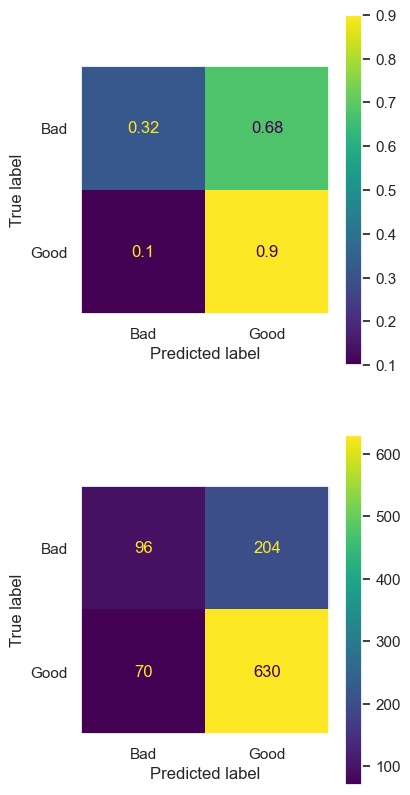

In [96]:
# Confusion matrix for the Logistic regression model
f, axs = plt.subplots(2, 1, figsize=(4, 10))
ConfusionMatrixDisplay.from_predictions(Y, lr_preds,
                                        display_labels=['Bad', 'Good'],
                                        normalize="true",
                                        ax=axs[0])
axs[0].grid()
ConfusionMatrixDisplay.from_predictions(Y, lr_preds,
                                        display_labels=['Bad', 'Good'],
                                        normalize=None,
                                        ax=axs[1])
axs[1].grid();

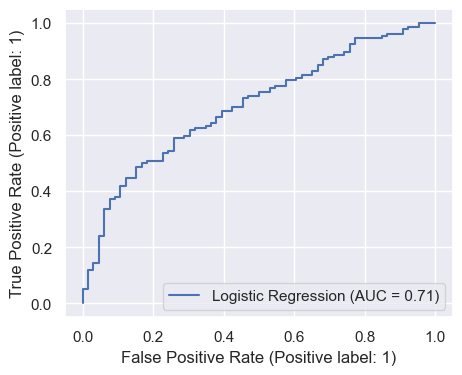

In [88]:
# Plot ROC AUC curve on the test set
f, axs = plt.subplots(1, 1, figsize=(5, 4))
RocCurveDisplay.from_estimator(gs_lr.best_estimator_, testX, testY, 
                               name="Logistic Regression",
                               ax=axs);

In [34]:
# Classification report for Logistic Regression
print(classification_report(Y, lr_preds, target_names=['Bad', 'Good']))

              precision    recall  f1-score   support

         Bad       0.58      0.32      0.41       300
        Good       0.76      0.90      0.82       700

    accuracy                           0.73      1000
   macro avg       0.67      0.61      0.62      1000
weighted avg       0.70      0.73      0.70      1000



AUC on the *test* set is 70% while 74% when cross validated. We note that the model predicts the sample as `good` (1) in most cases, including when it shouldn't (which results in many false positives). We also note that both precision, recall (equivalent to the diagonal) and the f1-score are pretty low for the `bad` (0) class. 

### Random Forest

Train and evaluate a Random Forest model.

We can exclude the pipeline since we don't need to scale the data. The `n_estimators` parameter specify how many individual trees the model compose of. More trees normally mean that it can better learn the data. We will tune this hyperparameter together with `max_depth`, which specifies how deep each tree can grow (deeper trees can split the data more fine-grained, but there is a larger risk of overfitting). 

In [174]:
%%time

# Specify model and subsequent hyperparameters to tune
rf = RandomForestClassifier(random_state=99)
parameters = {'n_estimators': Integer(10, 200, prior='uniform'),
              'max_depth': Integer(2, 8, prior='uniform'),
              'min_samples_split': Integer(2, 5, prior='uniform'),
}

# Perform hyperparameter tuning with BayesSearchCV over 10 folds with AUC as refit metric.
gs_rf = BayesSearchCV(rf, parameters, cv=10, scoring=scoring, 
                      refit="auc", random_state=500, n_iter=10)

# Fit the BayesSearchCV object to the train data
gs_rf.fit(trainX, trainY)

# Run nested cross-validation over 10 folds
rf_scores = cross_validate(gs_rf, X, Y, cv=10, n_jobs=-1, verbose=1,
                           return_train_score=True, scoring=scoring)

# Make cross-validated predictions 
rf_preds = cross_val_predict(gs_rf, X, Y, cv=10, n_jobs=-1, verbose=3)

time.sleep(1)
for score in rf_scores:
        print(f"{score:<17}: {np.mean(rf_scores[score]):.2f}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   12.3s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   18.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   12.4s remaining:   29.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   12.6s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   19.2s finished


fit_time         : 11.05
score_time       : 0.01
test_auc         : 0.78
train_auc        : 0.93
test_specificity : 0.51
train_specificity: 0.69
test_recall      : 0.92
train_recall     : 0.98
test_accuracy    : 0.74
train_accuracy   : 0.85
CPU times: user 9.82 s, sys: 1.8 s, total: 11.6 s
Wall time: 46 s


In [175]:
# Save best RF model
best_rf_model = gs_rf.best_estimator_
print(f"Best model: {gs_rf.best_estimator_}")
joblib.dump(best_rf_model, 'models/rf_model_pipeline.pkl')

Best model: RandomForestClassifier(max_depth=7, n_estimators=75, random_state=99)


['models/rf_model_pipeline.pkl']

In [176]:
%%bash

model="rf_model_pipeline.pkl"
sizeKB=$(du -k "models/$model" | cut -f 1)
echo Size for $model is $sizeKB kb

Size for rf_model_pipeline.pkl is 644 kb


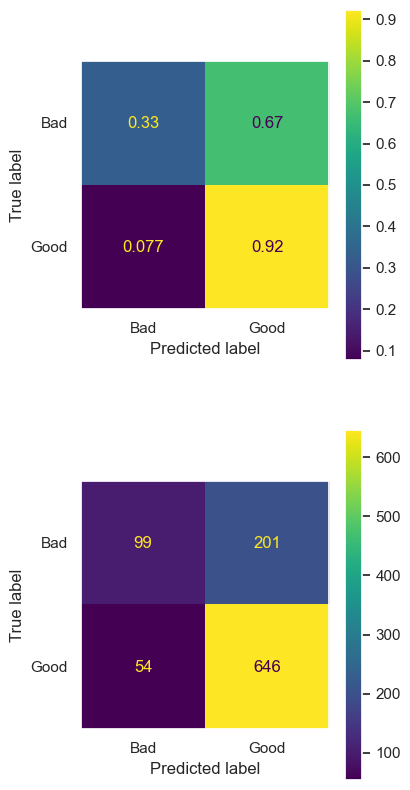

In [177]:
# Confusion matrix for Random Forest
f, axs = plt.subplots(2, 1, figsize=(4, 10))
ConfusionMatrixDisplay.from_predictions(Y, rf_preds,
                                        display_labels=['Bad', 'Good'],
                                        normalize="true",
                                        ax=axs[0])
axs[0].grid()
ConfusionMatrixDisplay.from_predictions(Y, rf_preds,
                                        display_labels=['Bad', 'Good'],
                                        normalize=None,
                                        ax=axs[1])
axs[1].grid();

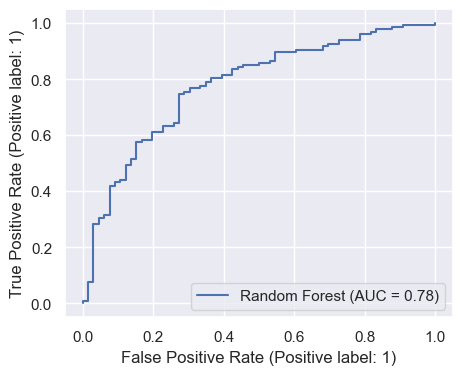

In [178]:
# Plot ROC AUC curve on the test set
f, axs = plt.subplots(1, 1, figsize=(5, 4))
RocCurveDisplay.from_estimator(gs_rf.best_estimator_, testX, testY, 
                               name="Random Forest",
                               ax=axs);

In [179]:
# Classification report for Random Forest
print(classification_report(Y, rf_preds, target_names=['Bad', 'Good']))

              precision    recall  f1-score   support

         Bad       0.65      0.33      0.44       300
        Good       0.76      0.92      0.84       700

    accuracy                           0.74      1000
   macro avg       0.70      0.63      0.64      1000
weighted avg       0.73      0.74      0.72      1000



AUC on both the test set and cross-validated is slightly better at 78%. Random Forest also seem to predict the sample as `good` (1) in most cases, including when it shouldn't (which results in many false positives). Although perhaps more equally distributed than for Logistic regression, precision, recall (equivalent to the diagonal) and the f1-score are very low for the `bad` (0) class here as well. 


Additionally, we note that Random Forest takes over 20 times longer to train than Logistic Regression. We would normally expect Random Forest to take longer, and this is something that should be taken into account when choosing the final model. 

### LightGBM

In [166]:
%%time

# Specify model and subsequent hyperparameters to tune. There are many more parameters to choose from
lgbm = LGBMClassifier(random_state=99)
parameters = {'n_estimators': Integer(10, 200, prior='uniform'),
              'max_depth': Integer(2, 8, prior='uniform'),
              'num_leaves': Integer(20, 60, prior='uniform'),
}

# Perform hyperparameter tuning with BayesSearchCV over 10 folds with AUC as refit metric.
# LightGBM is faster than RF so we can try more combinations (20 instead of 10)
gs_lgbm = BayesSearchCV(lgbm, parameters, cv=10, scoring=scoring, 
                       refit="auc", random_state=500, n_iter=20)

# Fit the BayesSearchCV object to the train data
gs_lgbm.fit(trainX, trainY)

# Run nested cross-validation over 10 folds
lgbm_scores = cross_validate(gs_lgbm, X, Y, cv=10, n_jobs=-1, verbose=1,
                           return_train_score=True, scoring=scoring)

# Make cross-validated predictions 
lgbm_preds = cross_val_predict(gs_lgbm, X, Y, cv=10, n_jobs=-1, verbose=3)

time.sleep(1)
for score in lgbm_scores:
        print(f"{score:<17}: {np.mean(lgbm_scores[score]):.2f}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   10.1s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   10.6s remaining:   24.8s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   11.3s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.9s finished


fit_time         : 8.99
score_time       : 0.00
test_auc         : 0.78
train_auc        : 0.89
test_specificity : 0.57
train_specificity: 0.69
test_recall      : 0.89
train_recall     : 0.93
test_accuracy    : 0.75
train_accuracy   : 0.83
CPU times: user 1min 40s, sys: 54.3 s, total: 2min 34s
Wall time: 59.1 s


In [167]:
# Save best LightGBM model
best_lgbm_model = gs_lgbm.best_estimator_
print(f"Best model: {gs_lgbm.best_estimator_}")
joblib.dump(best_lgbm_model, 'models/lgbm_model_pipeline.pkl')

Best model: LGBMClassifier(max_depth=2, n_estimators=138, num_leaves=20, random_state=99)


['models/lgbm_model_pipeline.pkl']

In [168]:
%%bash

model="lgbm_model_pipeline.pkl"
sizeKB=$(du -k "models/$model" | cut -f 1)
echo Size for $model is $sizeKB kb

Size for lgbm_model_pipeline.pkl is 140 kb


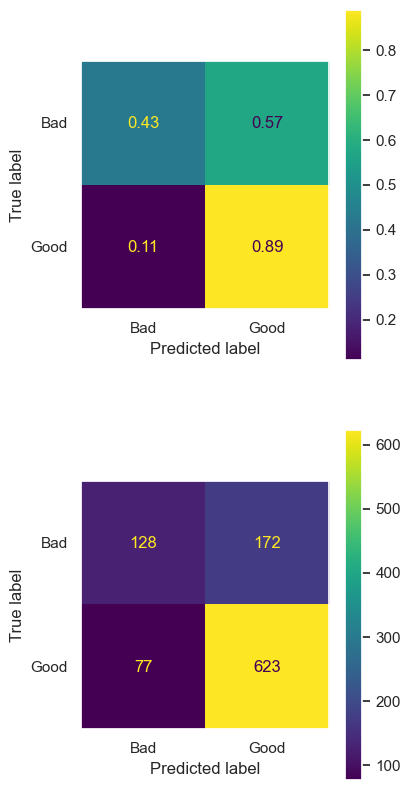

In [169]:
# Confusion matrix for LightGBM
f, axs = plt.subplots(2, 1, figsize=(4, 10))
ConfusionMatrixDisplay.from_predictions(Y, lgbm_preds,
                                        display_labels=['Bad', 'Good'],
                                        normalize="true",
                                        ax=axs[0])
axs[0].grid()
ConfusionMatrixDisplay.from_predictions(Y, lgbm_preds,
                                        display_labels=['Bad', 'Good'],
                                        normalize=None,
                                        ax=axs[1])
axs[1].grid();

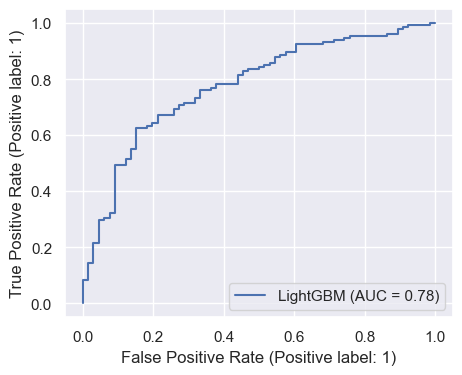

In [170]:
# Plot ROC AUC curve on the test set
f, axs = plt.subplots(1, 1, figsize=(5, 4))
RocCurveDisplay.from_estimator(gs_lgbm.best_estimator_, testX, testY, 
                               name="LightGBM",
                               ax=axs);

In [171]:
# Classification report for LightGBM
print(classification_report(Y, lgbm_preds, target_names=['Bad', 'Good']))

              precision    recall  f1-score   support

         Bad       0.62      0.43      0.51       300
        Good       0.78      0.89      0.83       700

    accuracy                           0.75      1000
   macro avg       0.70      0.66      0.67      1000
weighted avg       0.74      0.75      0.74      1000



LightGBM achieves a slightly lower AUC of 76% on the test set than Random Forest while its cross-validated AUC is equal at 78%. Although it's not as fast as Logistic Regression, it's faster than Random Forest.



## Summary

Visually display how the Logistic Regression, Random Forest and the LightGBM models perform.

Note that the following AUC scores differ from the AUC plots above because they're the median over all 10 cv-folds. This is a more reliable estimate of the models' performance due to the small dataset.

In [180]:
def get_results(df, score):
    """ Function for extracting train and test scores. """
    score = score.lower()
    return pd.DataFrame({f'train_{score}': df[f'train_{score}'],
                         f'test_{score}': df[f'test_{score}']})


def add_median_labels(ax, fmt='.2f'):
    """ Function for plotting the median on a boxplot.
        https://stackoverflow.com/questions/38649501/labeling-boxplot-in-seaborn-with-median-value
    """
    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
    lines_per_box = int(len(lines) / len(boxes))
    for median in lines[4:len(lines):lines_per_box]:
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if (median.get_xdata()[1] - median.get_xdata()[0]) == 0 else y
        text = ax.text(x, y, f'{value:{fmt}}', ha='center', va='center',
                       fontweight='bold', color='white')
        # create median-colored border around white text for contrast
        text.set_path_effects([
            path_effects.Stroke(linewidth=3, foreground=median.get_color()),
            path_effects.Normal(),
        ])

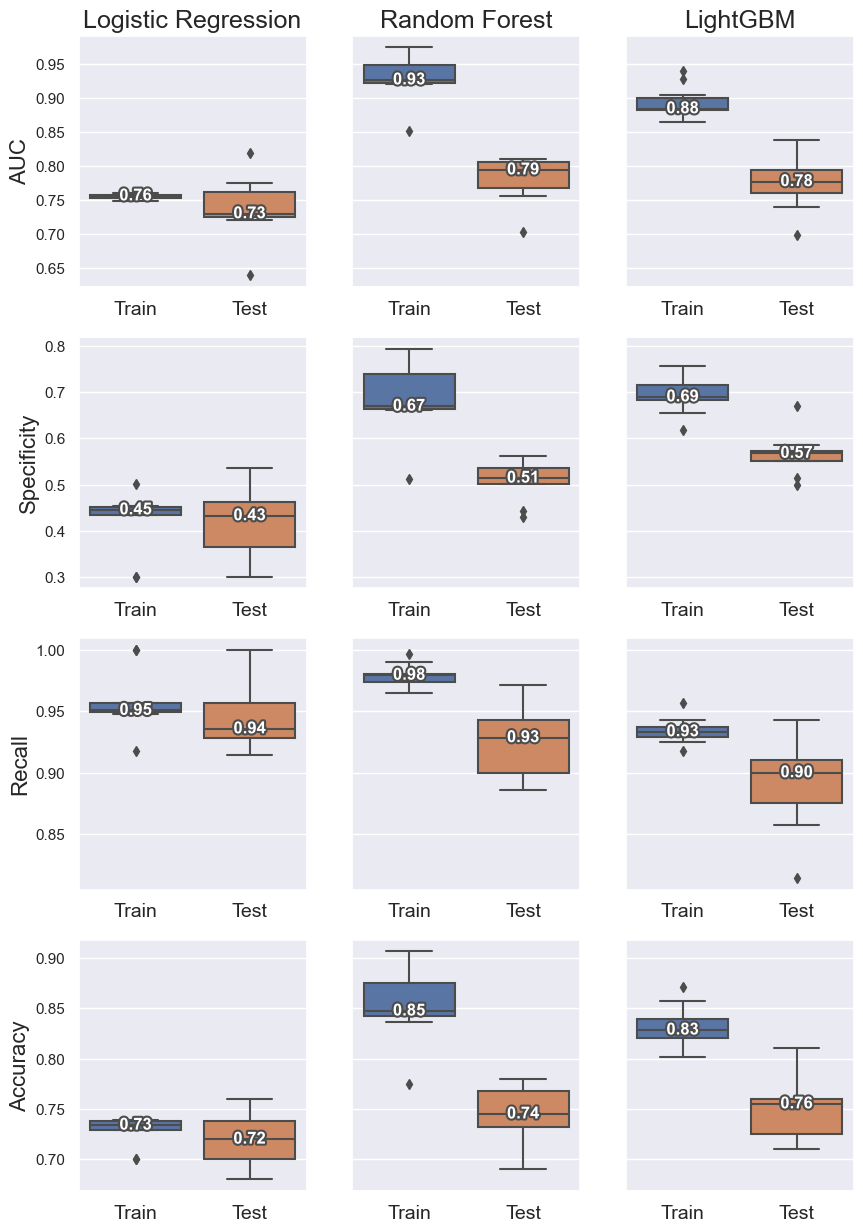

In [181]:
# Convert the scores to DataFrames
lr_scores = pd.DataFrame(lr_scores)
rf_scores = pd.DataFrame(rf_scores)
lgbm_scores = pd.DataFrame(lgbm_scores)

# Plot the train and test results by metric for the models. Share y-axis by metric
f, axs = plt.subplots(4, 3, figsize=(10, 15), sharey='row')

for i, name in enumerate(["AUC", "Specificity", "Recall", "Accuracy"]):
    # Logistic regression
    sns.boxplot(data=get_results(lr_scores, name), ax=axs[i][0])
    if i == 0: axs[i][0].set_title("Logistic Regression", size=18)
    axs[i][0].set_ylabel(name, size=16)
    axs[i][0].set_xticks([0, 1], ['Train', 'Test'], size=14)
    add_median_labels(axs[i][0])

    # Random Forest
    sns.boxplot(data=get_results(rf_scores, name), ax=axs[i][1])
    if i == 0: axs[i][1].set_title("Random Forest", size=18)
    axs[i][1].set_xticks([0, 1], ['Train', 'Test'], size=14)
    add_median_labels(axs[i][1])

    # LightGBM
    sns.boxplot(data=get_results(lgbm_scores, name), ax=axs[i][2])
    if i == 0: axs[i][2].set_title("LightGBM", size=18)
    axs[i][2].set_xticks([0, 1], ['Train', 'Test'], size=14)
    add_median_labels(axs[i][2]);

We conclude that both Random Forest and the LightGBM models achieve similar cross-validated AUC scores of 78% and 79%, respectively. However, LightGBM has higher specificity (57% vs. 51%) and accuracy (76% vs 74%) while being around 4x faster to train. The resulting model size is also around 5 times smaller. The only disadvantage is lower Recall. 

The financial industry might additionally value *not* giving a loan to someone with *bad* credit risk more than they *do* giving a loan to someone with *good* credit risk. Thus, higher specificity might be desired. Taking these things into account, we will move forward with the LightGBM model. 


The Logistic Regression model is less performant across all metrics, but is much faster to train than the others. 